In [22]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from pathlib import Path

In [23]:
### path where apples images and masks are stored
train_images_path = 'apples/apples'

In [24]:
def load_filenames(path):
    ### find all apple images and masks
    included_extensions = ['jpg','jpeg','png']
    file_names = [fn for fn in os.listdir(path) if any(fn.endswith(ext) for ext in included_extensions)]
    return file_names

In [25]:
file_names = load_filenames(train_images_path)

In [26]:
print(file_names)

['apple_3.jpg', 'apple_2_mask.png', 'apple_3_mask.png', 'apple_1.jpg', 'apple_2.jpg', 'apple_1_mask.png']


In [27]:
### create the whole path of each file
files = []
for f in file_names:
    path_of_file = train_images_path + '/' + f
    files.append(path_of_file)

In [28]:
## sort the files by name
files = sorted(files)

In [29]:
print(files)

['apples/apples/apple_1.jpg', 'apples/apples/apple_1_mask.png', 'apples/apples/apple_2.jpg', 'apples/apples/apple_2_mask.png', 'apples/apples/apple_3.jpg', 'apples/apples/apple_3_mask.png']


In [30]:
## create 
pairs = []
i = 0
while i < (len(files) - 1):
    pairs.append((files[i],files[i+1]))
    i += 2
print(pairs)

[('apples/apples/apple_1.jpg', 'apples/apples/apple_1_mask.png'), ('apples/apples/apple_2.jpg', 'apples/apples/apple_2_mask.png'), ('apples/apples/apple_3.jpg', 'apples/apples/apple_3_mask.png')]


Processing pair of images: ('apples/apples/apple_1.jpg', 'apples/apples/apple_1_mask.png')
Shape of the image is: (640, 480, 3)
Processing pair of images: ('apples/apples/apple_2.jpg', 'apples/apples/apple_2_mask.png')
Shape of the image is: (397, 500, 3)
Processing pair of images: ('apples/apples/apple_3.jpg', 'apples/apples/apple_3_mask.png')
Shape of the image is: (491, 600, 3)


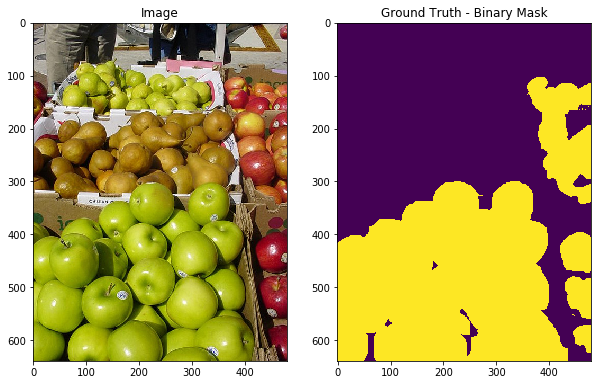

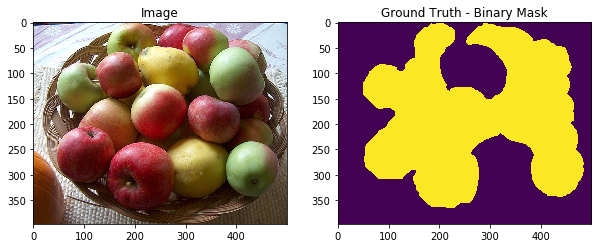

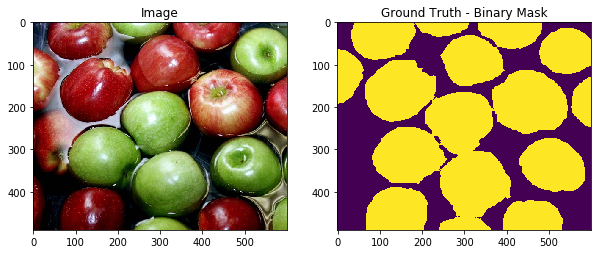

In [31]:
# In these two lists we store the pixels of each class apple/no apple
apple_pixels = []
non_apple_pixels = []

## process in pairs every apple image and its ground tuth mask
for (image,ground_truth) in pairs:
    
    print("Processing pair of images: " + str((image,ground_truth)))
    
    ## read the specific image
    image = plt.imread(image)
    
    print("Shape of the image is: " + str(image.shape))
    
    ## normalise the image, diving by the max value of a pixel in RGB
    ## in this way the max value is set to 1
    image = image / 255
    
    ## Read ground truth mask
    ## Create a binary matrix representation of the mask we read.
    mask = plt.imread(ground_truth)
    height = np.array(mask).shape[0]
    width = np.array(mask).shape[1]

    binary_mask = np.zeros((height,width))
    for i in range(0,height):
        for j in range(0,width):
            if(mask[i][j][2] != 0):
                binary_mask[i][j] = 1
            else:
                binary_mask[i][j] = 0
    
    
    ## create a list of pixels for each of the two classes apples/mon apples
    ## Based on the image and the mask we read
    for i in range(binary_mask.shape[0]):
        for j in range(binary_mask.shape[1]):
            ## if the respective pixel corresponds to apple class
            if binary_mask[i, j] != 0:
                apple_pixels.append(image[i,j])
            ## if the respective pixels does not correspond to apple class
            else:
                non_apple_pixels.append(image[i,j])
                
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(image)
    ax1.set_title('Image')
    ax2.imshow(binary_mask)
    ax2.set_title('Ground Truth - Binary Mask')
    
plt.show()

In [32]:
### Here we compute the total pixelss we have available for the training
### We calculate also two priors (Apple and Non Apple Prior)

apple_pixels = np.asarray(apple_pixels).T
non_apple_pixels = np.asarray(non_apple_pixels).T

print("Apple Pixels have shape of: " + str(apple_pixels.shape))
print("Non apple Pixels have shape of: " + str(non_apple_pixels.shape))

### total number of pixels apples + non apples
total_pixels = apple_pixels.shape[1] + non_apple_pixels.shape[1]
apple_prior = apple_pixels.shape[1] / total_pixels
non_apple_prior = non_apple_pixels.shape[1] / total_pixels

print("Total pixels: " + str(total_pixels))
print("Apple Prior: " + str(apple_prior))
print("Non Apple Prior: " + str(non_apple_prior))

Apple Pixels have shape of: (3, 429536)
Non apple Pixels have shape of: (3, 370764)
Total pixels: 800300
Apple Prior: 0.5367187304760714
Non Apple Prior: 0.4632812695239285


In [33]:
def gaussian_probability(data, mean, covariance):
    data = data - mean[:, None]
    return np.power(np.linalg.det(2 * np.pi * covariance), -0.5) * np.exp(-0.5 * (data.T.dot(np.linalg.inv(covariance)) * data.T).sum(1))

In [34]:
## compute the log likelihood
def log_likelihood(data, mixGaussEst):
       
    log_likelihoods = np.zeros((mixGaussEst['k'], data.shape[1]))

    for k in range(mixGaussEst['k']): 
        log_likelihoods[k, :] = mixGaussEst['weight'][k]*gaussian_probability(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :,k])

    return np.asscalar(np.sum(np.log(np.sum(log_likelihoods, axis=0))))


In [35]:
# Expectation step
def E_step(responsibilities,mixGaussEst,data):

    for k in range(mixGaussEst.get('k')):
        responsibilities[k, :] = mixGaussEst['weight'][k] * \
        gaussian_probability(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k])

    responsibilities /= np.sum(responsibilities, axis=0) + sys.float_info.min
            
    return responsibilities

In [36]:
def M_step(responsibilities,mixGaussEst,data):
    
    responsibility = np.sum(responsibilities, axis=1)
       
    for k in range(mixGaussEst.get('k')):
                
        current_responsibility = responsibilities[k, :]
        
        ## update the weights
        mixGaussEst['weight'][k] = (np.sum(current_responsibility) / np.sum(responsibilities))
        ## update the mean
        mixGaussEst['mean'][:, k] = (data @ current_responsibility / np.sum(current_responsibility))
        ## update the covariance
        new_m = (data - mixGaussEst['mean'][:, k][:, None])
        mixGaussEst['cov'][:, :, k] = ((new_m * current_responsibility[None, :]) @ (new_m.T) / responsibility[k])
        
    return mixGaussEst

In [37]:
## calculate mean and covariance
def calculate_mean_and_cov(data):
    mean = np.mean(data, axis=1)
    return (mean,(1 / data.shape[1] * (data - mean[:, None]) @ (data - mean[:, None]).T))

In [38]:
def model_initialization(data,k):
    
    ## number of pixels and number of channels we have 
    nDims, nData = data.shape
    
    ## calculate the mean and the covariance of the data
    mean,cov = calculate_mean_and_cov(data)
    
    init_type = 0
    
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    
    if(init_type==1):
        mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
        mixGaussEst['mean'] = mean[:, None] * (0.5 + np.random.uniform(size=(k)))
        mixGaussEst['cov'] = \
        (2 + 0.4 * np.random.normal(size=(k)))[None, None] * cov[:, :, None] 
    else:
        mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
        mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
        mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
        for cGauss in range(k):
            mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    
    return mixGaussEst

In [39]:
def plot_likelihood(iterations,likelihood):
    
    plt.plot(iterations, likelihood, color='green', label='Log-Likelihood')
    plt.title('Log Likelihood over iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Log-Likelihood')
    plt.legend()
    plt.show()
    plt.figure()

Here we fit our Gaussian Mixture Model

In [40]:
def GaussianMixtureModel(data,k):
    
        mixGaussEst = model_initialization(data,k)
    
        ## initialize the responsibilities with zeros
        responsibilities = np.zeros(shape=(k,data.shape[1]))
        
        ## compute the log likelihood for the initial arbitrary configuration of parameters
        log_lkl = log_likelihood(data, mixGaussEst)
        
        print("Log likelihood before the first iter is: " + str(log_lkl))


        # Number of iterations
        iteration_count = 80
        
        iter_list = []
        log_list = []

        for cIter in range(iteration_count):
            
            iter_list.append(cIter)
            
            log_list.append(log_lkl)
            
            ## perform expectation step and update the responsibilities
            responsibilities = E_step(responsibilities,mixGaussEst,data)
            
            mixGaussEst = M_step(responsibilities,mixGaussEst,data)
            ## perform maximisation step and update the model parameters based on the new responsibilities
            
            log_lkl = log_likelihood(data, mixGaussEst)
            
            print("Log likelihood of iter: " + str(cIter) + " is " + str(log_lkl))
            
            #log_likelihood_delta = abs(new_log_likelihood - log_likelihood)
            
        plot_likelihood(iter_list,log_list)
            
        return mixGaussEst

/home/apostolos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if __name__ == '__main__':


Log likelihood before the first iter is: -2489435.5424798103
Log likelihood of iter: 0 is 286727.0539568656
Log likelihood of iter: 1 is 290274.25391601655
Log likelihood of iter: 2 is 302876.71270852984
Log likelihood of iter: 3 is 342956.2398759161
Log likelihood of iter: 4 is 430435.97949503124
Log likelihood of iter: 5 is 544443.1690599687
Log likelihood of iter: 6 is 637281.9444188968
Log likelihood of iter: 7 is 667447.719810781
Log likelihood of iter: 8 is 682149.8031362107
Log likelihood of iter: 9 is 696837.1490041538
Log likelihood of iter: 10 is 712149.8300705634
Log likelihood of iter: 11 is 723244.1583252326
Log likelihood of iter: 12 is 729402.3368462228
Log likelihood of iter: 13 is 733039.9509602456
Log likelihood of iter: 14 is 735656.2288938743
Log likelihood of iter: 15 is 737783.0454873765
Log likelihood of iter: 16 is 739596.9490469481
Log likelihood of iter: 17 is 741126.5842849776
Log likelihood of iter: 18 is 742353.1397999014
Log likelihood of iter: 19 is 74327

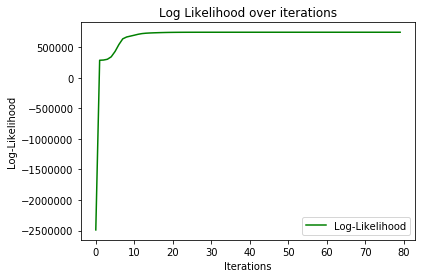

Log likelihood before the first iter is: -2748015.8949334645
Log likelihood of iter: 0 is 409492.27335153124
Log likelihood of iter: 1 is 409492.30034495366
Log likelihood of iter: 2 is 409497.826827135
Log likelihood of iter: 3 is 410680.4246685273
Log likelihood of iter: 4 is 429037.8433736282
Log likelihood of iter: 5 is 451915.0528770679
Log likelihood of iter: 6 is 470353.41858745925
Log likelihood of iter: 7 is 483413.0524603865
Log likelihood of iter: 8 is 498146.2306280349
Log likelihood of iter: 9 is 512199.07742055785
Log likelihood of iter: 10 is 522689.7399140552
Log likelihood of iter: 11 is 530653.6324009242
Log likelihood of iter: 12 is 537602.6765451067
Log likelihood of iter: 13 is 550221.4225688064
Log likelihood of iter: 14 is 585269.3396496489
Log likelihood of iter: 15 is 627966.143606547
Log likelihood of iter: 16 is 643059.1293769411
Log likelihood of iter: 17 is 646026.7935649579
Log likelihood of iter: 18 is 647125.2186292053
Log likelihood of iter: 19 is 64784

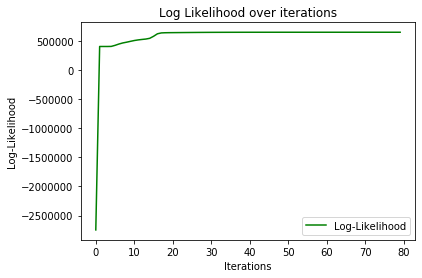

<Figure size 432x288 with 0 Axes>

In [41]:
apple_model = GaussianMixtureModel(apple_pixels,3)
non_apple_model = GaussianMixtureModel(non_apple_pixels,3)

In [42]:
def likelihood(data, mixGaussEst):
        result = np.zeros((mixGaussEst['k'],data.shape[1]))
        for k in range(mixGaussEst['k']):
            result[k,:] = mixGaussEst['weight'][k]*gaussian_probability(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k])
        return np.sum(result, axis=0)

In [43]:
def posterior_mask(image,apple_model,non_apple_model):
       
        y,x,z = image.shape

        apple_likelihood = likelihood(image.reshape(x*y,z).T,apple_model).reshape(y,x)
        non_apple_likelihood = likelihood(image.reshape(x*y,z).T,non_apple_model).reshape(y,x)
        
        normalisation_constant = (apple_likelihood * apple_prior)+ (non_apple_likelihood * non_apple_prior)
        
        apple_posterior = apple_likelihood * apple_prior / normalisation_constant

        return apple_posterior

Testing image: testApples/apple_1.jpg
A Mask for this file does not exist!


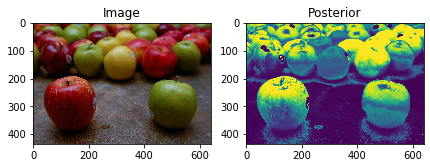

Testing image: testApples/apple_2.jpg
A Mask for this file exists and is: testApples/apple_2_mask.png


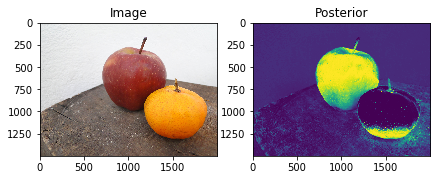

Testing image: testApples/apple_3.jpg
A Mask for this file does not exist!


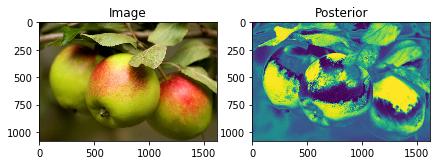

Testing image: testApples/apple_4.jpg
A Mask for this file does not exist!


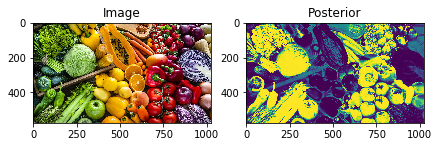

Testing image: testApples/apple_5.jpg
A Mask for this file does not exist!


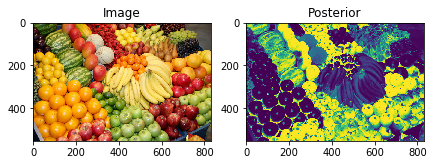

Testing image: testApples/apple_6.jpg
A Mask for this file does not exist!


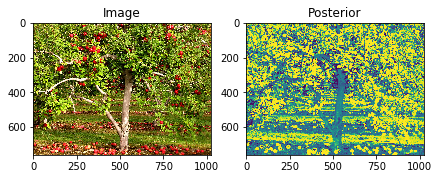

Testing image: testApples/apple_7.jpg
A Mask for this file does not exist!


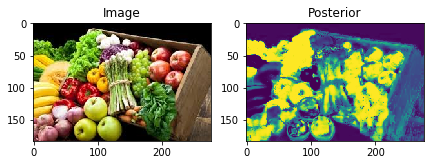

Testing image: testApples/apple_8.jpg
A Mask for this file does not exist!


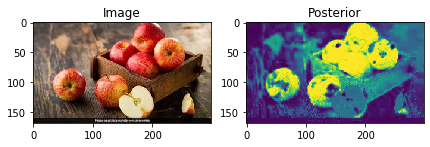

Testing image: testApples/apple_9.jpg
A Mask for this file does not exist!


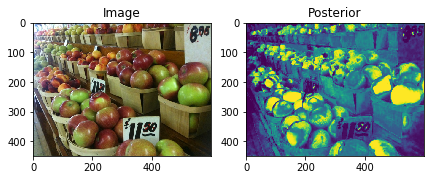

Testing image: testApples/apple_10.jpg
A Mask for this file does not exist!


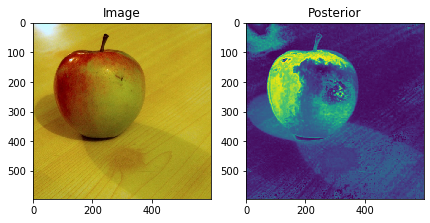

Testing image: testApples/apple_11.jpg
A Mask for this file does not exist!


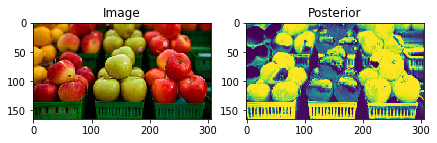

In [44]:
num_of_testing_images = 11
testing_directory = 'testApples'

for i in range(0,num_of_testing_images):
    
    image_name = testing_directory + '/' + 'apple_' + str(i+1) + '.jpg'
    mask_name = testing_directory + '/' + 'apple_' + str(i+1) + '_mask.png'
    
    print("Testing image: " + image_name)
    
    maskf = Path(mask_name)
    
    mask_flag = 0
    if maskf.is_file():
        print("A Mask for this file exists and is: " + mask_name)
        mask_flag = 1
    else:
        print("A Mask for this file does not exist!")
      
    ## read the image and normalise it
    img = plt.imread(image_name)
    img = img/255
    
     
    apple_posterior = posterior_mask(img,apple_model,non_apple_model)

            
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))
    ax1.imshow(img)
    ax1.set_title('Image')
    ax2.imshow(apple_posterior)
    ax2.set_title('Posterior')
    plt.show()